# Credit Score Classifier by Atul Gupta

## 1. Importing the dataset

In [3]:
import pandas as pd
import warnings
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import joblib
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

In [75]:
!conda install scikit-learn=1.2.1 -y

Channels:
 - defaults
Platform: osx-arm64
Solving environment: - warning  libmamba Added empty dependency for problem type SOLVER_RULE_UPDATE
failed

LibMambaUnsatisfiableError: Encountered problems while solving:
  - package scikit-learn-1.2.1-py310h313beb8_0 requires python >=3.10,<3.11.0a0, but none of the providers can be installed

Could not solve for environment specs
The following packages are incompatible
├─ pin-1 is installable and it requires
│  └─ python 3.12.* , which can be installed;
└─ scikit-learn 1.2.1**  is not installable because there are no viable options
   ├─ scikit-learn 1.2.1 would require
   │  └─ python >=3.10,<3.11.0a0 , which conflicts with any installable versions previously reported;
   ├─ scikit-learn 1.2.1 would require
   │  └─ python >=3.11,<3.12.0a0 , which conflicts with any installable versions previously reported;
   ├─ scikit-learn 1.2.1 would require
   │  └─ python >=3.8,<3.9.0a0 , which conflicts with any installable versions previously report

In [4]:
train_file = 'train.csv'
test_file = 'test.csv'

train = pd.read_csv(train_file)

In [5]:
train.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


FIXING GARBAGE VALUES IN SSN COLUMN

In [7]:
res = list(train['SSN'].unique())
# Regex to find strings containing digits
pattern = r'^\d{3}-\d{2}-\d{4}$'

# Filter list using regex
filtered = [item for item in res if not re.search(pattern, item)]

print(filtered)

['#F%$D@*&8']


Checking Customer_ID column

In [9]:
res = list(train['Customer_ID'].unique())
# Regex to find strings containing digits
pattern = r'^CUS.*'

# Filter list using regex
filtered = [item for item in res if not re.search(pattern, item)]

print(filtered)

[]


In [10]:
train["Payment_Behaviour"].replace('!@9#%8',np.nan,inplace=True)
train["Payment_of_Min_Amount"].replace('NM',np.nan,inplace=True)
train["SSN"].replace('#F%$D@*&8',np.nan,inplace=True)

In [11]:
train.isnull().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                          5572
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount       12007
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour            7600
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

In [12]:
Q1 = train['Num_Credit_Inquiries'].quantile(0.25)
Q3 = train['Num_Credit_Inquiries'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

Lower Bound: -6.0, Upper Bound: 18.0


In [13]:
min_age = 18
max_age = 100
max_num_credit_cards = 12
max_interest_rate = 50
max_num_loans = 10
max_num_credit_inquiries = 15
max_num_bank_accounts = 13
max_number_of_delayed_payments = 30
min_monthly_balance = -10000
max_monthly_balance = 10000
max_delay_from_due_date = 55
max_changed_credit_limit = 28
max_emi_per_month = 350

# Function to remove underscores from a string value
def remove_underscore(value):
    if isinstance(value, str):
        return value.replace('_', '')
    return value

# Function to check if a value falls between min_age and max_age
def check_valid_age(value):
    if value >= min_age and value <= max_age:
        return value
    return np.nan

# Function to check if max number of credit cards fall between expected boundaries.
def check_num_credit_cards(value):
    if 0 <= value <= max_num_credit_cards:
        return value
    return np.nan

# Function to check interest rate
def check_interest_rate(value):
    if value <= max_interest_rate:
        return value
    return np.nan

# Function to check maximum number of loans
def check_max_num_loan(value):
    if value >= 0 and value <= max_num_loans:
        return value
    return np.nan

# Function to check number of delayed payments    if isinstance(value, int) and value >= 0 and value <= max_number_of_delayed_payments:
def check_num_delayed_payments(value):
    if value >= 0 and value <= max_number_of_delayed_payments:
        return value
    return np.nan

# Function to check number of credit inquiries
def check_num_credit_inquiries(value):
    if value <= max_num_credit_inquiries:
        return value
    return np.nan

# Function to check outstanding debt
def check_outstanding_debt(value):
    if value >= 0:
        return value
    return np.nan

# Function to check credit history age
def check_credit_history_age(value):
    match = re.match(r'(\d+) Years and (\d+) Months', value)

    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        total_months = years * 12 + months
        return total_months
    return np.nan

def check_monthly_balance(value):
    if value >= min_monthly_balance and value <= max_monthly_balance:
        return value
    return np.nan

def check_num_bank_accounts(value):
    if 0 <= value <= max_num_bank_accounts:
        return value
    return np.nan

def check_delay_from_due_date(value):
    if 0 <= value <= max_delay_from_due_date:
        return value
    return np.nan

def check_changed_credit_limit(value):
    if value <= max_changed_credit_limit:
        return value
    return np.nan

def check_total_emi_per_month(value):
    if 0 <= value <= max_emi_per_month:
        return value
    return np.nan


# Function to perform preprocessing steps on a given dataset
def preprocessing(data):

    # Dropping the duplicate rows in the dataset
    data.drop_duplicates(inplace=True)

    integer_columns = ['Age','Num_Bank_Accounts','Num_Credit_Card','Interest_Rate','Num_of_Loan','Delay_from_due_date',
                      'Num_of_Delayed_Payment','Num_Credit_Inquiries']
    float_columns = ['Annual_Income','Monthly_Inhand_Salary','Changed_Credit_Limit','Outstanding_Debt','Credit_Utilization_Ratio',
                    'Total_EMI_per_month','Amount_invested_monthly','Monthly_Balance']

    data['Num_Credit_Inquiries'] = data['Num_Credit_Inquiries'].fillna(0)

    # Converting the entire dataset to strings and then removing underscores by mapping
    data = data.astype(str)
    data = data.applymap(remove_underscore)

    # Re-converting the columns to their respective dtypes after underscores are removed
    for column in integer_columns:
        data[column] = pd.to_numeric(data[column], errors='coerce').astype('Int64')

    for column in float_columns:
        data[column] = pd.to_numeric(data[column], errors='coerce').astype('float64')

    # Applying the defined map functions to clean individual rows.
    data['Age'] = data['Age'].apply(check_valid_age).astype('Int64')
    data['Interest_Rate'] = data['Interest_Rate'].apply(check_interest_rate).astype('Int64')
    data['Num_of_Loan'] = data['Num_of_Loan'].apply(check_max_num_loan).astype('Int64')
    data['Num_of_Delayed_Payment'] = data['Num_of_Delayed_Payment'].apply(check_num_delayed_payments).astype('Int64')
    data['Num_Credit_Inquiries'] = data['Num_Credit_Inquiries'].apply(check_num_credit_inquiries).astype('Int64') #FIX the boolean value issue
    data['Outstanding_Debt'] = data['Outstanding_Debt'].apply(check_outstanding_debt).astype('float64')
    data['Monthly_Balance'] = data['Monthly_Balance'].apply(check_monthly_balance).astype('float64')
    data['Credit_History_Age'] = data['Credit_History_Age'].apply(check_credit_history_age).astype('Int64')
    data['Num_Bank_Accounts'] = data['Num_Bank_Accounts'].apply(check_num_bank_accounts).astype('Int64')
    data['Num_Credit_Card'] = data['Num_Credit_Card'].apply(check_num_credit_cards).astype('Int64')
    data['Delay_from_due_date'] = data['Delay_from_due_date'].apply(check_delay_from_due_date).astype('Int64')
    data['Changed_Credit_Limit'] = data['Changed_Credit_Limit'].apply(check_changed_credit_limit).astype('float64')
    data['Total_EMI_per_month'] = data['Total_EMI_per_month'].apply(check_total_emi_per_month).astype('float64')
    
    
    data['Credit_Mix'] = data['Credit_Mix'].map({'Good':2,'Standard':1,'Bad':0}).astype('Int64')
    data['Payment_of_Min_Amount'] = data['Payment_of_Min_Amount'].map({'No':1,'Yes':0})

    payment_behavior_mapping = {
    'HighspentLargevaluepayments': 3,
    'HighspentMediumvaluepayments': 2,
    'HighspentSmallvaluepayments': 1,
    'LowspentLargevaluepayments': -1,
    'LowspentMediumvaluepayments': -2,
    'LowspentSmallvaluepayments': -3
    }

    data['Payment_Behaviour'] = data['Payment_Behaviour'].map(payment_behavior_mapping)

    # Replacing '' with np.nan throughout the dataset
    data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    data.replace('', np.nan, inplace=True)
    data.replace("nan", np.nan, inplace=True)
    
    return data

train = preprocessing(train)

train['Credit_Score'] = train['Credit_Score'].map({'Good':2,'Standard':1,'Poor':0})

In [14]:
def custom_one_hot_encoding(X):
    # Handle NaN and convert to string
    X["Type_of_Loan"] = X["Type_of_Loan"].fillna('missing').astype(str)
    
    # Extract unique loan types
    type_of_loan = set()
    
    # Process unique values
    for item in X["Type_of_Loan"].unique():
        loans = [
            loan.strip().replace('and', '').replace(' ', '') 
            for loan in item.split(',') 
            if loan.strip() not in ['', 'nan', 'missing']
        ]
        type_of_loan.update(loans)
    
    # Create new binary columns (initialize as int)
    for loan in type_of_loan:
        X[loan] = 0  # This defaults to int in pandas
    
    # Populate binary columns and enforce int type
    for index, row in X.iterrows():
        loans = [
            loan.strip().replace('and', '').replace(' ', '') 
            for loan in row["Type_of_Loan"].split(',') 
            if loan.strip() not in ['', 'nan', 'missing']
        ]
        for loan in loans:
            if loan in type_of_loan:
                X.at[index, loan] = 1
    
    # # Ensure all new columns are integers
    # for loan in type_of_loan:
    #     X[loan] = X[loan].astype(int)  # Explicit cast to int
    
    X.drop('Type_of_Loan', axis=1, inplace=True)
    return X

train = custom_one_hot_encoding(train)
train.rename(columns={'NotSpecified': 'LoanNotSpecified'}, inplace=True)

In [15]:
impute_mode = ['Age','Monthly_Inhand_Salary','Interest_Rate','Credit_Mix','Num_Credit_Inquiries','Payment_of_Min_Amount',
               'Payment_Behaviour','Num_of_Loan','Changed_Credit_Limit','Occupation','Name']
impute_mean = ['Amount_invested_monthly','Monthly_Balance']
impute_median = ['Credit_History_Age','Num_of_Delayed_Payment']
group = ['Customer_ID']

def impute_group_mode(columns_to_impute,df,group):
    for col in columns_to_impute:
        df[col] = df.groupby(group)[col].transform(
            lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
        )
    return df

def impute_group_median(columns_to_impute,df,group):
    for col in columns_to_impute:
        df[col] = df.groupby(group)[col].transform(
            lambda x: x.fillna(np.nan if not x.median() else x.median())
        )
    return df

def impute_group_mean(columns_to_impute,df,group):
    for col in columns_to_impute:
        df[col] = df.groupby(group)[col].transform(
            lambda x: x.fillna(x.mean() if x.mean() else np.nan)
        )
    return df

train = impute_group_mode(impute_mode, train, group)
train = impute_group_median(impute_median, train, group)
train = impute_group_mean(impute_mean, train, group)

train.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Score,PersonalLoan,AutoLoan,PaydayLoan,StudentLoan,Credit-BuilderLoan,HomeEquityLoan,LoanNotSpecified,DebtConsolidationLoan,MortgageLoan
0,0x1602,CUS0xd40,January,Aaron Maashoh,23.0,821-00-0265,Scientist,19114.12,1824.843333,3.0,...,2,1,1,0,0,1,1,0,0,0
1,0x1603,CUS0xd40,February,Aaron Maashoh,23.0,821-00-0265,Scientist,19114.12,1824.843333,3.0,...,2,1,1,0,0,1,1,0,0,0
2,0x1604,CUS0xd40,March,Aaron Maashoh,23.0,821-00-0265,Scientist,19114.12,1824.843333,3.0,...,2,1,1,0,0,1,1,0,0,0
3,0x1605,CUS0xd40,April,Aaron Maashoh,23.0,821-00-0265,Scientist,19114.12,1824.843333,3.0,...,2,1,1,0,0,1,1,0,0,0
4,0x1606,CUS0xd40,May,Aaron Maashoh,23.0,821-00-0265,Scientist,19114.12,1824.843333,3.0,...,2,1,1,0,0,1,1,0,0,0


In [16]:
train.isnull().sum()

ID                             0
Customer_ID                    0
Month                          0
Name                           0
Age                         5504
SSN                         5572
Occupation                     0
Annual_Income                  0
Monthly_Inhand_Salary          0
Num_Bank_Accounts           1336
Num_Credit_Card             2271
Interest_Rate                  0
Num_of_Loan                    0
Delay_from_due_date         4593
Num_of_Delayed_Payment       421
Changed_Credit_Limit         640
Num_Credit_Inquiries           0
Credit_Mix                     0
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age             0
Payment_of_Min_Amount          0
Total_EMI_per_month         7060
Amount_invested_monthly        0
Payment_Behaviour              0
Monthly_Balance                0
Credit_Score                   0
PersonalLoan                   0
AutoLoan                       0
PaydayLoan                     0
StudentLoa

In [17]:
identifiers = ['ID','Customer_ID','Name','SSN','Month','Occupation']
train.drop(identifiers,axis=1,inplace=True)
train.dropna(inplace=True)

In [18]:
numerical_cols = ['Age','Annual_Income','Monthly_Inhand_Salary','Num_Bank_Accounts','Num_Credit_Card','Interest_Rate','Num_of_Loan',
                  'Delay_from_due_date','Num_of_Delayed_Payment','Changed_Credit_Limit','Num_Credit_Inquiries','Outstanding_Debt',
                 'Credit_Utilization_Ratio','Credit_History_Age','Total_EMI_per_month','Amount_invested_monthly','Monthly_Balance']
target = 'Credit_Score'
categorical_columns = [col for col in train.columns if col not in numerical_cols and col != target]

In [19]:
scaler = MinMaxScaler()
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])

In [20]:
train = train.sample(frac=1).reset_index(drop=True)

In [21]:
train.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Credit_Score,PersonalLoan,AutoLoan,PaydayLoan,StudentLoan,Credit-BuilderLoan,HomeEquityLoan,LoanNotSpecified,DebtConsolidationLoan,MortgageLoan
0,0.195122,0.000045,0.035985,0.727273,0.727273,0.696970,0.666667,0.890909,0.892857,0.975645,...,1,1,0,1,1,0,0,0,1,0
1,0.097561,0.000158,0.041533,0.727273,0.636364,0.060606,0.333333,0.381818,0.392857,0.242969,...,1,0,0,1,1,0,0,0,0,0
2,0.341463,0.005073,0.722970,0.272727,0.363636,0.545455,0.222222,0.490909,0.642857,0.729777,...,2,1,0,0,1,0,0,0,0,0
3,0.134146,0.002667,0.382899,0.636364,0.636364,1.000000,0.222222,0.400000,0.392857,0.559872,...,0,1,0,0,0,0,0,0,1,0
4,0.134146,0.006363,0.884587,0.363636,0.090909,0.000000,0.111111,0.109091,0.428571,0.321832,...,1,0,0,1,0,0,0,0,0,0


In [22]:
print(train.corr()[target].sort_values(ascending=False))

Credit_Score                1.000000
Credit_Mix                  0.487354
Payment_of_Min_Amount       0.430475
Credit_History_Age          0.376691
Monthly_Inhand_Salary       0.193932
Monthly_Balance             0.183826
Age                         0.129846
Payment_Behaviour           0.111927
Credit_Utilization_Ratio    0.041185
Amount_invested_monthly     0.010101
Annual_Income               0.006441
Total_EMI_per_month        -0.069002
LoanNotSpecified           -0.124719
HomeEquityLoan             -0.127470
PersonalLoan               -0.132074
Credit-BuilderLoan         -0.133522
StudentLoan                -0.134419
PaydayLoan                 -0.134932
MortgageLoan               -0.134992
DebtConsolidationLoan      -0.140721
AutoLoan                   -0.146317
Changed_Credit_Limit       -0.180534
Num_of_Loan                -0.347433
Num_of_Delayed_Payment     -0.352792
Num_Bank_Accounts          -0.367549
Outstanding_Debt           -0.379042
Num_Credit_Card            -0.394982
N

In [23]:
train.isnull().sum()

Age                         0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
PersonalLoan                0
AutoLoan                    0
PaydayLoan                  0
StudentLoan                 0
Credit-BuilderLoan          0
HomeEquityLoan              0
LoanNotSpecified            0
DebtConsolidationLoan       0
MortgageLoan                0
dtype: int64

In [24]:
train.shape

(80137, 30)

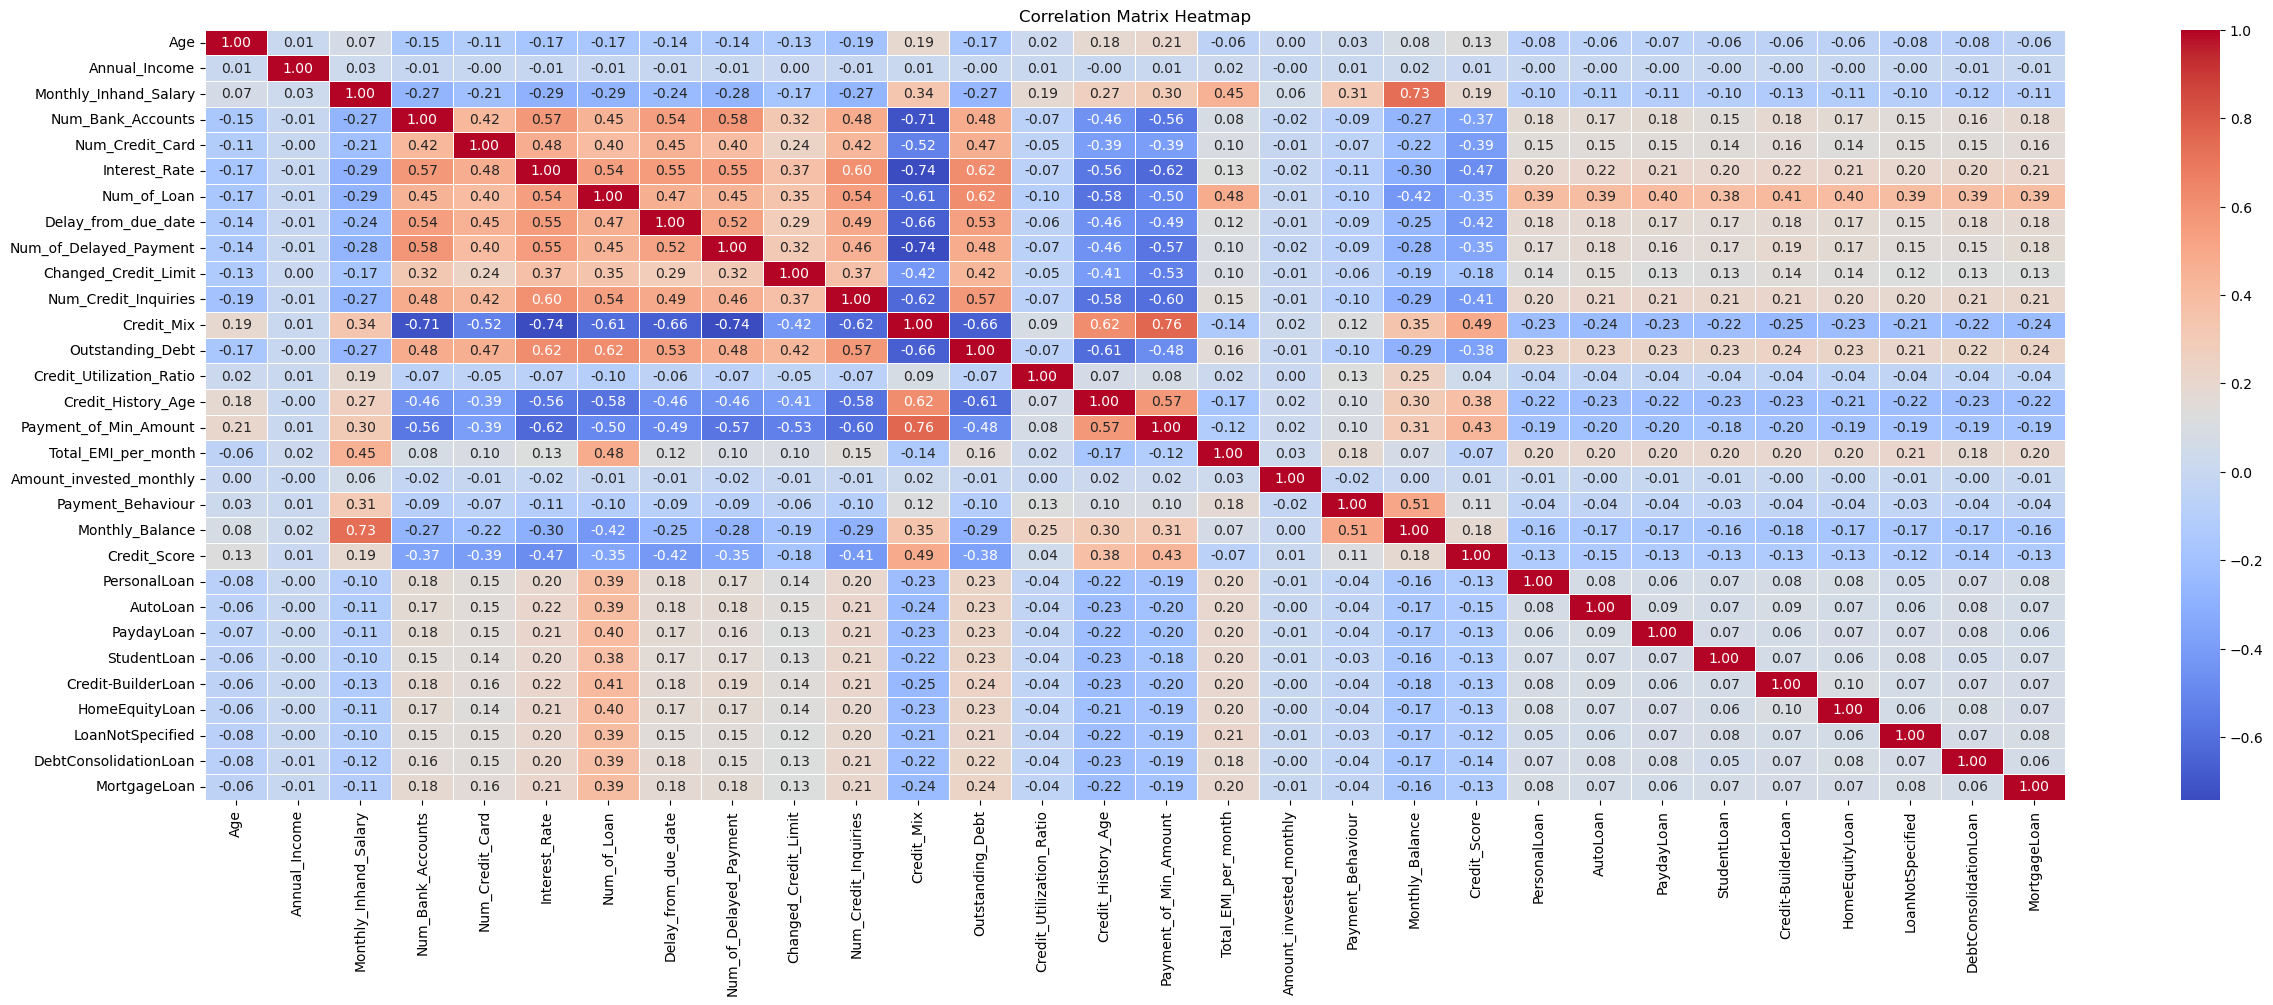

In [25]:
# Correlation matrix
numerical_columns = train.select_dtypes(include=['float64', 'int64','int32'])
corr_matrix = numerical_columns.corr()

plt.figure(figsize=(30, 10))

# Correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix Heatmap')

plt.show()

In [26]:
# Sample dataset (Replace with your own dataset)
X = train.drop(columns=target)  # Replace 'target_column' with your actual target variable
y = train[target]

# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

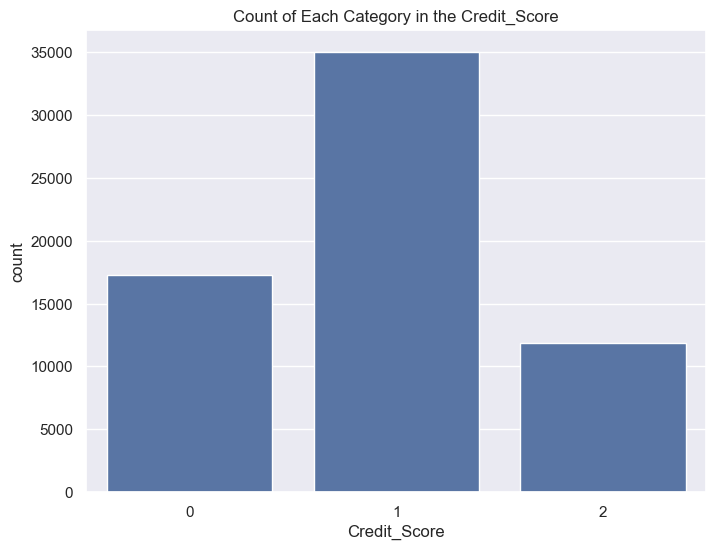

In [27]:
# Checking dataset balancing before oversampling

sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(x=pd.Series(y_train))

plt.title('Count of Each Category in the Credit_Score')
plt.show()

In [28]:
# Oversampling
sample = SMOTE(sampling_strategy='all', random_state=42)
X_train, y_train = sample.fit_resample(X_train, y_train)
X_test, y_test = sample.fit_resample(X_test, y_test)

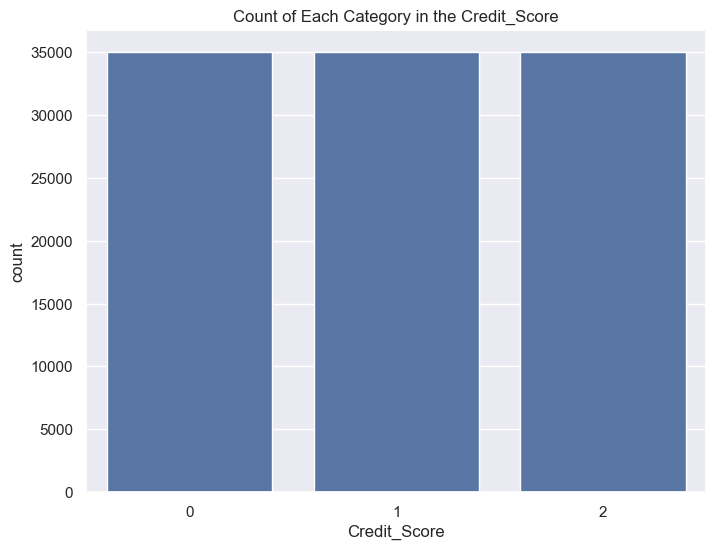

In [29]:
# Balanced dataset
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(x=pd.Series(y_train))

plt.title('Count of Each Category in the Credit_Score')
plt.show()

In [30]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

In [31]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [32]:
# XGBoost
xgb_model = XGBClassifier(objective='multi:softmax',num_class = 3, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [33]:
# Bagging Classifier
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)

Decision Tree Model:
Accuracy: 0.77

Confusion Matrix:
 [[6580 1537  642]
 [1193 6632  934]
 [ 648 1186 6925]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77      8759
           1       0.71      0.76      0.73      8759
           2       0.81      0.79      0.80      8759

    accuracy                           0.77     26277
   macro avg       0.77      0.77      0.77     26277
weighted avg       0.77      0.77      0.77     26277

Random Forest Model:
Accuracy: 0.84

Confusion Matrix:
 [[7362  859  538]
 [1044 7014  701]
 [ 121  997 7641]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      8759
           1       0.79      0.80      0.80      8759
           2       0.86      0.87      0.87      8759

    accuracy                           0.84     26277
   macro avg       0.84      0.84      0.84     26277
weighted avg       0.

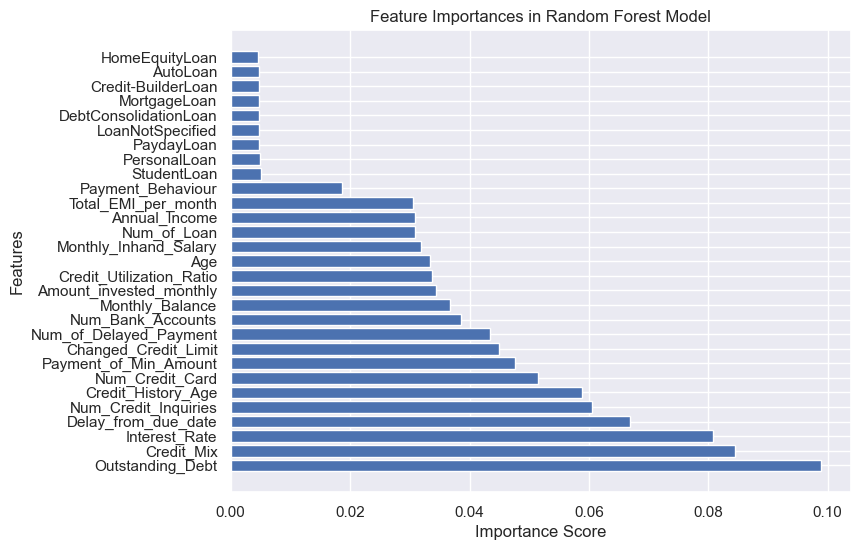

XGBoost Model:
Accuracy: 0.82

Confusion Matrix:
 [[6979  886  894]
 [1087 6691  981]
 [ 282  663 7814]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      8759
           1       0.81      0.76      0.79      8759
           2       0.81      0.89      0.85      8759

    accuracy                           0.82     26277
   macro avg       0.82      0.82      0.82     26277
weighted avg       0.82      0.82      0.82     26277

Bagging Classifier Model:
Accuracy: 0.84

Confusion Matrix:
 [[7365  791  603]
 [1069 7042  648]
 [ 228  842 7689]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      8759
           1       0.81      0.80      0.81      8759
           2       0.86      0.88      0.87      8759

    accuracy                           0.84     26277
   macro avg       0.84      0.84      0.84     26277
weighted avg       0.8

In [34]:
# Evaluate the models
models = [
    ("Decision Tree", dt_model, y_pred_dt, y_test),
    ("Random Forest", rf_model, y_pred_rf, y_test),
    ("XGBoost", xgb_model, y_pred_xgb, y_test),
    ("Bagging Classifier", bagging_model, y_pred_bagging, y_test)
]

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for model_name, model, y_pred, y_true in models:
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_scores.append(accuracy)
    conf_matrix = confusion_matrix(y_true, y_pred)
    classification_rep = classification_report(y_true, y_pred)

    precision_scores.append(precision_score(y_true, y_pred,average='macro'))
    recall_scores.append(recall_score(y_true,y_pred,average='macro'))
    f1_scores.append(f1_score(y_true, y_pred,average='macro'))

    print(f"{model_name} Model:")
    print(f'Accuracy: {accuracy:.2f}')
    print('\nConfusion Matrix:\n', conf_matrix)
    print('\nClassification Report:\n', classification_rep)
    print("="*40)
    if model_name == 'Random Forest':
      feature_importances = rf_model.feature_importances_

      # Create a DataFrame with feature names and their importance scores
      feature_importance_df = pd.DataFrame({
          'Feature': X_train.columns,
          'Importance': feature_importances
      })

      # Sort the DataFrame by importance in descending order
      feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

      # Plot the feature importances
      plt.figure(figsize=(8, 6))
      plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
      plt.xlabel('Importance Score')
      plt.ylabel('Features')
      plt.title('Feature Importances in Random Forest Model')
      plt.show()

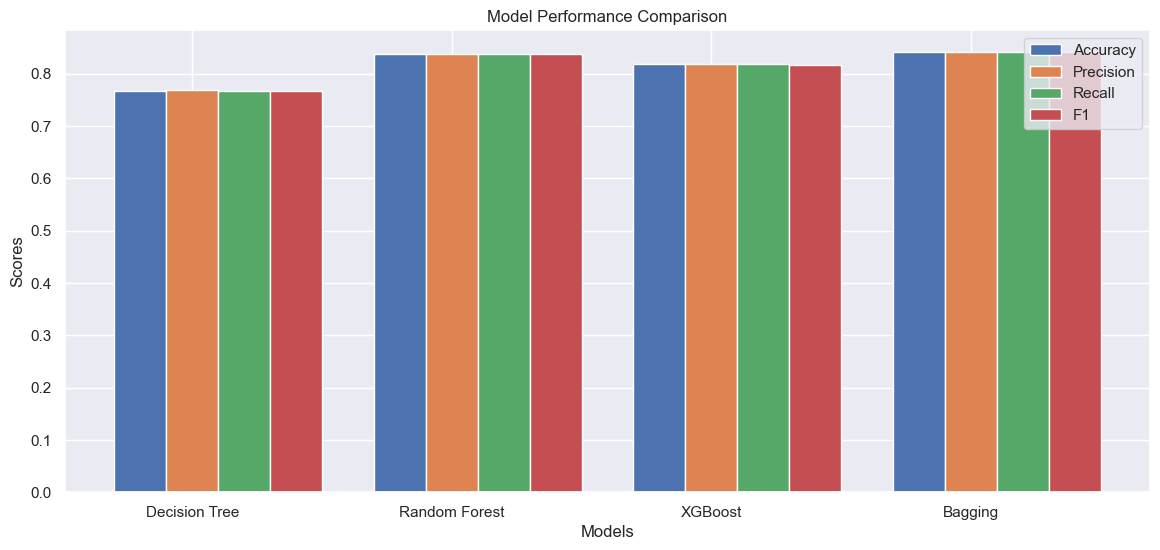

In [35]:
model_names = ['Decision Tree', 'Random Forest', 'XGBoost', 'Bagging']

# Number of models
num_models = len(model_names)


fig, ax = plt.subplots(figsize=(14, 6))

# Bar width
bar_width = 0.2
bar_positions = np.arange(num_models)

# Plot bars for each metric
plt.bar(bar_positions - bar_width, accuracy_scores, width=bar_width, label='Accuracy')
plt.bar(bar_positions, precision_scores, width=bar_width, label='Precision')
plt.bar(bar_positions + bar_width, recall_scores, width=bar_width, label='Recall')
plt.bar(bar_positions + 2 * bar_width, f1_scores, width=bar_width, label='F1')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(bar_positions, model_names)
plt.legend()

# Show the plot
plt.show()

In [36]:
# Save model artifacts
joblib.dump(bagging_model, 'model.joblib')

['model.joblib']

In [37]:
!tar czvf model.tar.gz model.joblib inference.py

a model.joblib
a inference.py


I am creating a model to predict "Credit Score" as (Good, Average, Poor). I have the following columns:

1. Age (Numerical and Required)
2. Annual Income (Numerical and Required)
3. Monthly Inhand Salary (Numerical and Required)
4. Number of Bank Accounts (Numerical and Optional)
5. Number of Credit Cards (Numerica and Optional)
6. Interest Rate on Credit Card (Numerical and Optional)
7. Number of Loans (Numerical and Optional)
8. Average delay (in days) in payment from the due date (Numerical and Required)
9. Average number of delayed payments per month (Numerical and Required)
10. Percent change in credit limit (Numerical and Optional)
11. Number of Credit Inquiries (Numerical and Required)
12. Credit Mix (Categorical [Good, Standard, Bad] and Required)
13. Outstanding Debt (Numerical and Required)
14. Credit Utilization Ratio (Numerical and Required)
15. Credit History Age in Months (Numerical and Required)
16. Do you pay minimum amount every month? (Categorical and Required)
17. Total EMI (Equated Monthly Installment) per month (Numerical and optional)
18. Amount Invested Monthly (Numerical and Optional)
19. Payment Behavior (Categorical['High_spent_Small_value_payments','Low_spent_Large_value_payments','Low_spent_Medium_value_payments','Low_spent_Small_value_payments','High_spent_Medium_value_payments','High_spent_Large_value_payments'] and Required)
20. Average Monthly Balance (Numerical and Required)
21. Type of loans (multi-select categorical['Auto Loan', 'Credit-Builder Loan', 'Personal Loan', 'Home Equity Loan', 'Other','Payday Loan', 'Student Loan', 'Mortgage Loan'] and optional)

I want you to create a web page that has a form to accept all these values from the user, a submit button, and space to print the model's result.

Please add the following changes:

1. Add a "How does it work?" hyperlink next to the title.
2. Change the 'Type_of_Loan' to a multi-select checkbox.
3. Add a limit of acceptable values in the "Age" field to be between 18 and 100 (both inclusive).
4. Change "Average Delayed Payments/Month" to accept only integers.
5. Add a limit of acceptable values in the "Credit Utilization Ratio" field to be between 0 and 100 (both inclusive).